In [1]:
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.


In [4]:
data_path = '../Data/fer2013/fer2013.csv'
df = pd.read_csv(data_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [2]:
def processString(s):
    s = s.split()
    img = np.zeros((48, 48))
    for i in range(48):
        for j in range(48):
            img[i][j] = s[48*i + j]
    return np.array(img)        

In [11]:
string = df['pixels'][0]

In [12]:
len(string.split())

2304

In [18]:
img = processString(df['pixels'][0])

In [25]:
np.sum(df['Usage'] == 'PublicTest')

3589

In [20]:
import matplotlib.pyplot as plt

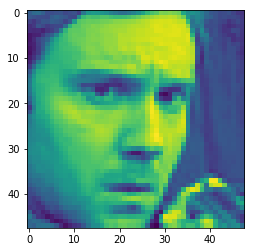

In [21]:
plt.imshow(img, cmap = 'gray')

In [3]:
def getDataset():
    data_path = '../Data/fer2013/fer2013.csv'
    df = pd.read_csv(data_path)
    X_train = []; y_train = []
    X_test = []; y_test = []
    X_val = []; y_val = []
    for index, row in df.iterrows():
        if(row['Usage'] == 'Training'):
            X_train.append(processString(row['pixels']))
            y_train.append(row['emotion'])
        elif(row['Usage'] == 'PublicTest'):
            X_val.append(processString(row['pixels']))
            y_val.append(row['emotion'])
        else:
            X_test.append(processString(row['pixels']))
            y_test.append(row['emotion'])
    
    #preprocess the data
    mean = np.mean(X_train, axis = 0)
    X_train -= mean
    X_test -= mean
    X_val -= mean
    data = {}
    data['X_train'] = np.array(X_train); data['y_train'] = np.array(y_train)
    data['X_val'] = np.array(X_val); data['y_val'] = np.array(y_val)
    data['X_test'] = np.array(X_test); data['y_test'] = np.array(y_test)
    return data

In [4]:
data = getDataset()

In [91]:
data['X_train'].shape

(28709, 48, 48)

In [92]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

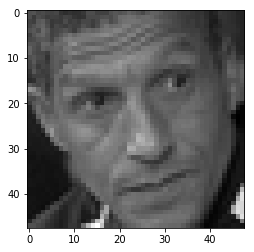

In [43]:
plt.imshow(data['X_val'][25], cmap = 'gray')

In [46]:
np.mean(data['X_train'], axis = 0).shape

(48, 48)

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

In [8]:
X_train = data['X_train'].reshape(data['X_train'].shape[0], 48, 48, 1)
X_test = data['X_test'].reshape(data['X_test'].shape[0], 48, 48, 1)
X_val = data['X_val'].reshape(data['X_val'].shape[0], 48, 48, 1)
y_train = np_utils.to_categorical(data['y_train'])
y_test = np_utils.to_categorical(data['y_test'])
y_val = np_utils.to_categorical(data['y_val'])
model = Sequential()

# input: (48, 48, 1)
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (48, 48, 1)))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation = 'softmax'))

sgd = SGD(lr = 0.01, decay = 1e-5, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 100, epochs = 8)
#score = model.evaluate(X_test, y_test, batch_size = 100)

In [7]:
score = model.evaluate(X_test, y_test, batch_size = 100)
score

3589/3589 [==============================] - 11s 3ms/step


[12.170535023546577, 0.24491501794481849]

In [62]:
unique, counts = np.unique(data['y_train'], return_counts = True)

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 12, 12, 64)        0         
__________

In [64]:
print('Number of occurence of each class in the dataset = %s' % dict(zip(unique, counts)))

Number of occurence of each class in the dataset = {0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}


In [82]:
data['y_train'].shape

(28709,)

In [87]:
data['X_train'].shape

(28709, 48, 48)

In [112]:
preds = np.argmax(model.predict(X_test), axis = 1)

In [114]:
preds[:40]

array([3, 6, 3, 4, 4, 3, 4, 3, 2, 3, 5, 3, 5, 3, 3, 6, 5, 5, 4, 3, 3, 3,
       6, 6, 3, 4, 5, 6, 6, 3, 4, 4, 0, 4, 0, 6, 5, 0, 3, 3], dtype=int64)